In [1]:
!pwd
import os
os.chdir('..')
import bilevel
from bilevel.build_all_models import *
from bilevel.OnlineLinearExpert import *
from bilevel.OnlineTreeExpert import *
from bilevel.utils import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/home/jupyter-kriach/md_github_lat/multigroupcode/multigroup-code/iclr_res


In [2]:
%%time
df_adult = pd.read_csv('./data_small/adult_reconstruction.csv')

numeric_all = ['hours-per-week', 'age', 'capital-gain', 'capital-loss', 'education-num', 'income']
cat_feat =  ['workclass', 'marital-status', 'relationship', 'native-country', 'occupation', 'race', 'sex']

df_adult.drop(['education'], axis = 1, inplace=True)
df_adult_mm = numeric_scaler(df_adult, numeric_all)
df_adult_mm_oh = one_hot(df_adult_mm, cat_feat)
df_adult_mm_oh.drop(cat_feat, axis = 1, inplace=True) # drop the categorics that were used to one hot encode
df_adult_mm_oh = df_adult_mm_oh * 1.0 # make bool true, false into 1.0, 0.0
df_adult_mm_oh.head()

A_t_age = pd.concat([df_adult['age'] <= 35,  # young
        (df_adult['age'] > 35) & (df_adult['age'] <= 50), # middle
        df_adult['age'] > 50], # old
             axis = 1, keys = ['young', 'middle', 'old'])

A_t_edu = pd.concat([df_adult['education-num'] <= 9, df_adult['education-num'] >= 10], axis = 1, 
                keys = ['HighSchool&less', 'College&more'])

A_t_sex = pd.concat([df_adult['sex'] == 'Male', df_adult['sex'] == 'Female'], axis = 1, keys = ['Male', 'Female'])

A_t_race = pd.concat([df_adult['race'] == 'White', df_adult['race'] == 'Asian-Pac-Islander',
                      df_adult['race'] == 'Amer-Indian-Eskimo', df_adult['race'] == 'Other',
                      df_adult['race'] == 'Black'], axis = 1, keys = ['White', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other', 'Black'])

A_t_adult_groups = pd.concat([A_t_age, A_t_edu, A_t_sex, A_t_race], axis=1)
A_t_adult_groups['always_on'] = True
A_t_adult_groups *= 1
A_t_adult_groups.sum(axis=0)

CPU times: user 119 ms, sys: 21.9 ms, total: 141 ms
Wall time: 138 ms


young                 22792
middle                16881
old                    9858
HighSchool&less       22584
College&more          26947
Male                  33174
Female                16357
White                 42441
Asian-Pac-Islander     1519
Amer-Indian-Eskimo      471
Other                   406
Black                  4694
always_on             49531
dtype: int64

In [3]:
%%time
from bilevel.Groupwise_seedruns import BuildGroupwise_diffseeds
ds_obj = BuildGroupwise_diffseeds(df_adult_mm_oh, 'income', A_t_adult_groups)
ds_obj.build_all_seeds()
ds_obj.build_df_res()

100%|██████████| 49531/49531 [00:24<00:00, 1996.32it/s]


CPU times: user 36min 4s, sys: 1min 21s, total: 37min 26s
Wall time: 4min 41s


In [4]:
# subgroups_list = [['young', 'middle', 'old'], ['HighSchool&less', 'College&more'], ['Male', 'Female'],
# ['White', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other', 'Black'], ['always_on']]

# from bilevel.Groupwise_seedruns import plot_subgroups
# plot_subgroups(ds_obj, subgroups_list)

In [6]:
# pd.concat([plot_ob.df_base_meansd, plot_ob.df_Anh_meansd], axis=1)

In [7]:
%%time
ds_obj.build_regret_curve()

CPU times: user 10min 6s, sys: 19.6 s, total: 10min 25s
Wall time: 1min 18s


In [ ]:
import pickle
# with open('adult_gw_ob.pkl', 'wb') as handle:
#     pickle.dump(ds_obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# with open('adult_gw_ob.pkl', 'rb') as handle:
#     ds_obj = pickle.load(handle)

adult_gw = load_ob('adult_gw_ob.pkl')

In [8]:
save_ob('adult_gw_clipped_altprob.pkl', ds_obj)

young 22792


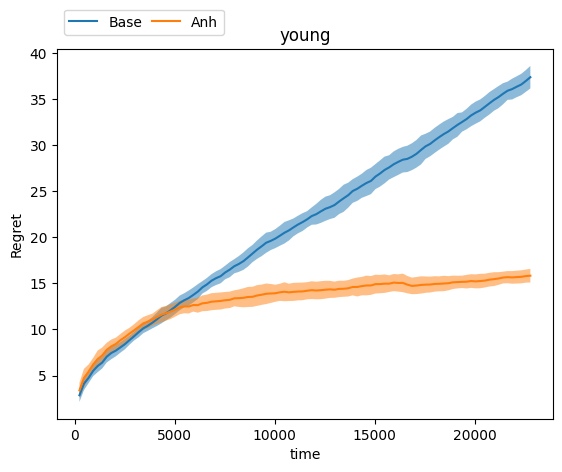

middle 16881


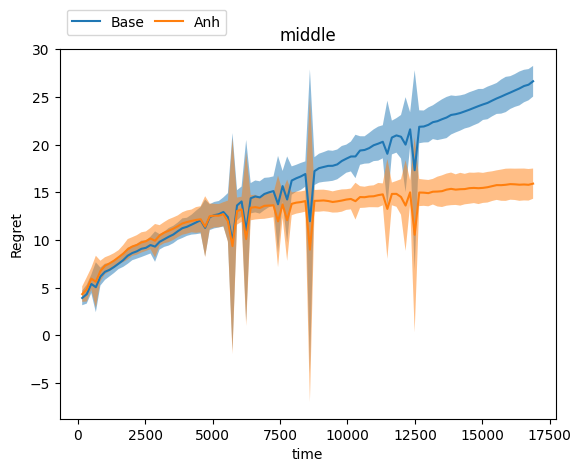

old 9858


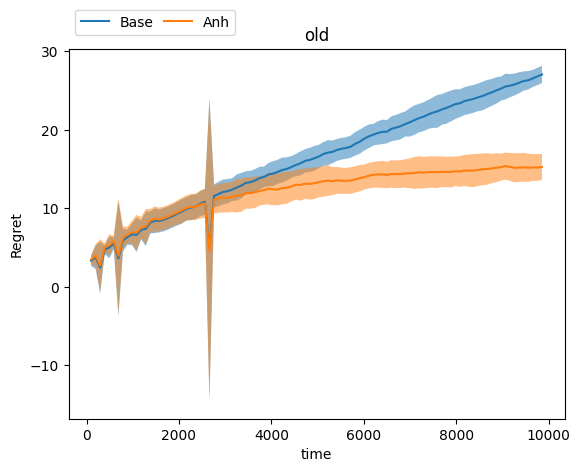

HighSchool&less 22584


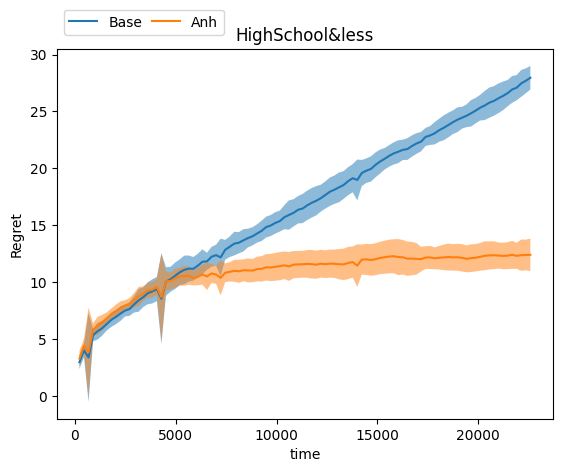

College&more 26947


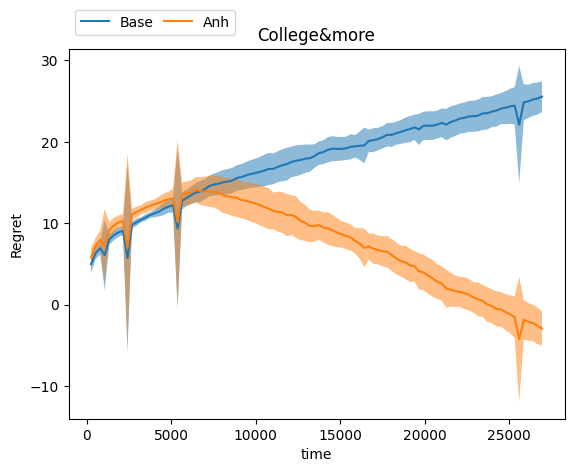

Male 33174


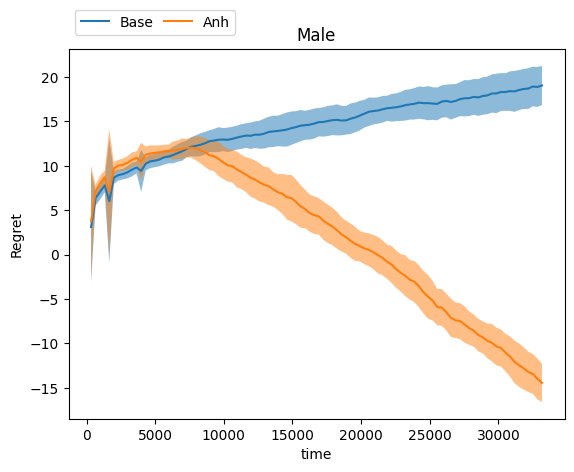

Female 16357


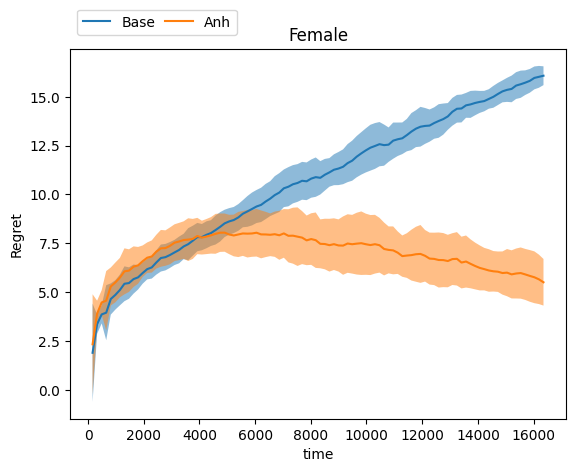

White 42441


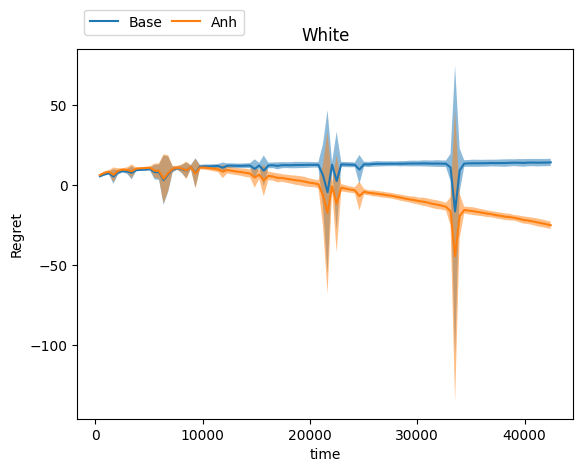

Asian-Pac-Islander 1519


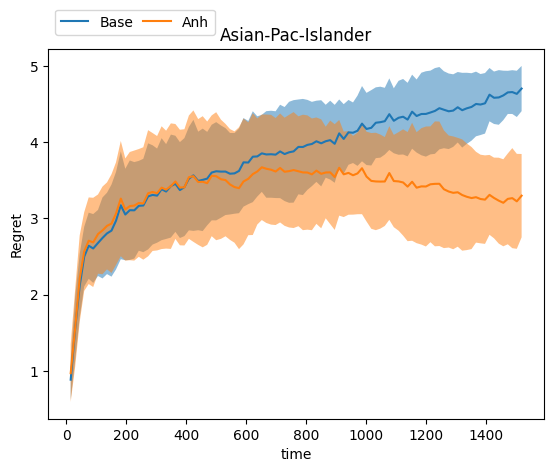

Amer-Indian-Eskimo 471


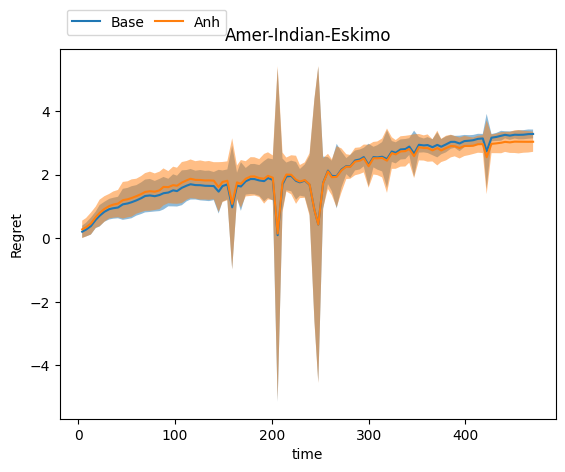

Other 406


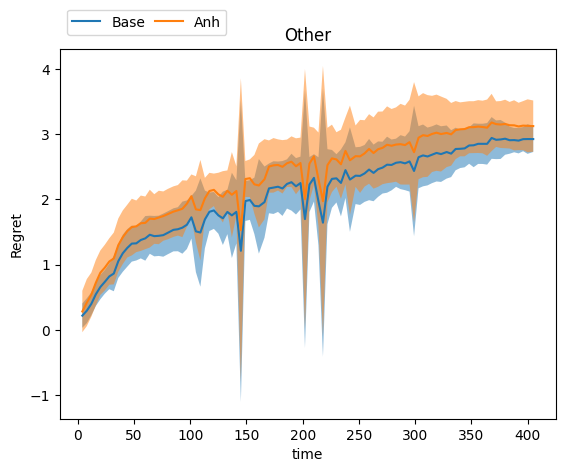

Black 4694


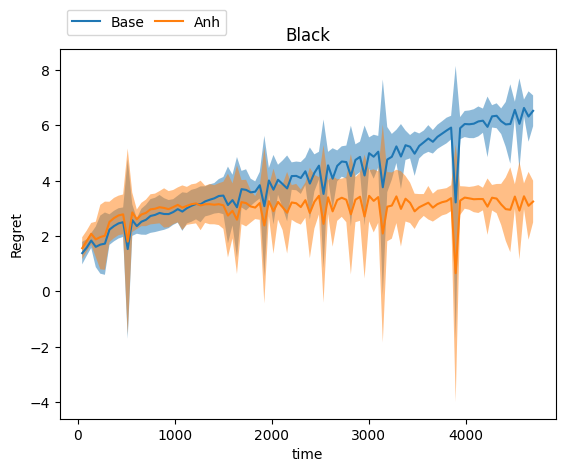

always_on 49531


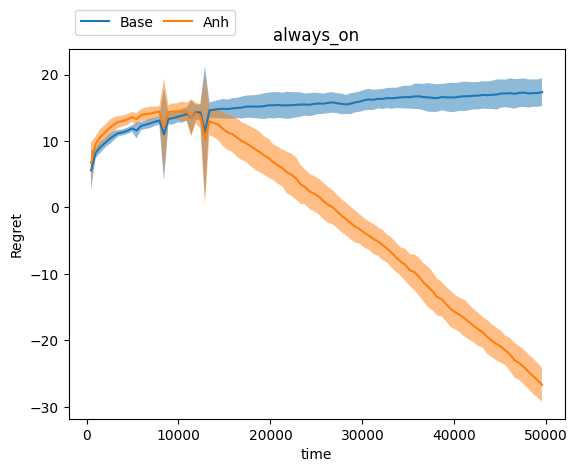

In [9]:
from bilevel.Groupwise_seedruns import plot_regret_curve_with_std # with clipped y_vals of the least squares predictor
plot_regret_curve_with_std(ds_obj, 'adult_income_plots')

In [ ]:
# Testing best in hindsight vs ridge batch

In [10]:
def performance_diff(ds_obj):
    df_res = pd.concat([ds_obj.df_base_meansd, ds_obj.df_Anh_meansd], axis=1)
    df_res['base_minus_Anh'] = df_res['mean_base'] - df_res['mean_Anh']
    df_res['discount_from_base'] = (df_res['base_minus_Anh'] / df_res['mean_base'])*100
    return df_res

In [11]:
performance_diff(ds_obj)

,mean_base,std_base,mean_Anh,std_Anh,base_minus_Anh,discount_from_base
young,450.168510,1.276885,428.654780,0.772434,21.513731,4.779039
middle,624.831559,1.705613,614.092428,1.678134,10.739130,1.718724
old,434.394247,1.149837,422.603265,1.762204,11.790982,2.714350
HighSchool&less,526.493605,1.094041,510.939828,1.507124,15.553778,2.954220
College&more,982.900711,1.998353,954.410646,2.218582,28.490065,2.898570
Male,1182.621030,2.315097,1149.151020,2.255335,33.470011,2.830155
Female,326.773286,0.503465,316.199454,1.262581,10.573832,3.235831
White,1326.996324,2.398741,1287.681326,2.495409,39.314998,2.962706
Asian-Pac-Islander,59.481154,0.288898,58.075731,0.568999,1.405423,2.362804
Amer-Indian-Eskimo,12.380835,0.144627,12.135839,0.335952,0.244996,1.978830
